<a href="https://colab.research.google.com/github/pgurazada/causal_inference/blob/master/07_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q dowhy econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 34.1 MB/s eta 0:00:00


In [2]:
import graphviz

import numpy as np
import pandas as pd
import networkx as nx

from scipy import stats
from dowhy import CausalModel
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier
from tqdm import tqdm

# Example 1

## Data

In [5]:
earnings_data = pd.read_csv(r"ml_earnings.csv")

In [6]:
earnings_data.sample(10)

,age,took_a_course,earnings
83,26,True,143772.0
12,35,False,174856.0
28,22,False,118836.0
14,27,False,136437.0
126,25,True,143428.0
120,42,True,214445.0
184,29,False,143288.0
102,32,False,159917.0
153,21,False,115543.0
183,21,False,116586.0


In [7]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

## Estimating Causal Models

In [9]:
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

6695.570882852306

In [10]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [11]:
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)

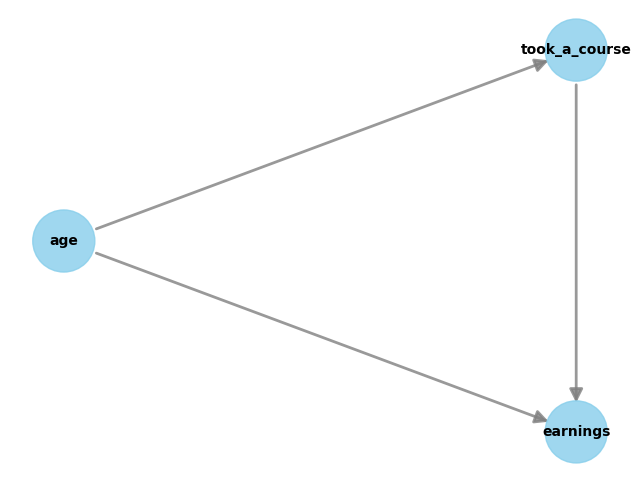

In [12]:
model.view_model()

In [13]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Approximate matching.

In [15]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2}
)

print(f'Estimate of causal effect (matching): {estimate.value}')

Estimate of causal effect (matching): 10464.5


Inverse propensity score used in weighted least squares regression.

In [23]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate'
)

print(f'Estimate of causal effect (matching): {estimate.value}')

Estimate of causal effect (matching): 10313.566831120319
